In [29]:
!pip install -q segmentation-models-pytorch

In [30]:
import torch
import tqdm
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import seaborn as sns
import segmentation_models_pytorch as smp
from torch.nn.init import trunc_normal_
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchvision.models.vision_transformer import VisionTransformer
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path

In [31]:
import kagglehub
path = kagglehub.dataset_download("humansintheloop/plant-semantic-segmentation")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plant-semantic-segmentation


In [ ]:
class PlantsSegmentationDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str) -> None:
        self.classes = ("Background", "Plant")
        self._img_dir: Path = Path(images_dir)
        self._images: dict[str, Path] = {}
        self._masks_dir: Path = Path(masks_dir)
        self._masks: dict[str, Path] = {}
        for file in self._img_dir.rglob("*"):
            if file.suffix not in [".jpeg", ".jpg", ".png", ".bmp"]:
                continue
            self._images[file.stem] = file
        for file in self._masks_dir.rglob("*"):
            if file.suffix not in [".png", ".bmp"]:
                continue
            self._masks[file.stem] = file
        self.img_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((224, 224)
            # , interpolation=transforms.InterpolationMode.NEAREST
                              ),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.squeeze(0)),
            transforms.Lambda(lambda x: torch.round(x)),
            transforms.Lambda(lambda x: (x * 1).type(torch.int64)),
        ])

    def __len__(self) -> int:
        return len(self._images)

    @property
    def num_classes(self) -> int:
        return len(self.classes)

    def __getitem__(self, idx: int) -> tuple:
        images = list(self._images.items())
        key = images[idx][0]
        img_file = images[idx][1]
        image = Image.open(img_file).convert("RGB")
        mask = Image.open(self._masks[key]).convert("L")
        return self.img_transform(image), self.mask_transform(mask)

In [ ]:
dataset_dir = f"{path}/Plant segmentation"
dataset = PlantsSegmentationDataset(dataset_dir + "/images", dataset_dir + "/masks")
trainset, testset = random_split(dataset, [0.8, 0.2])
print(len(trainset), len(testset))

116 28


In [34]:
n_epochs = 20

In [35]:
# load data
batch_size = 8
# shuffle because of our data are sorted by labels
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size)

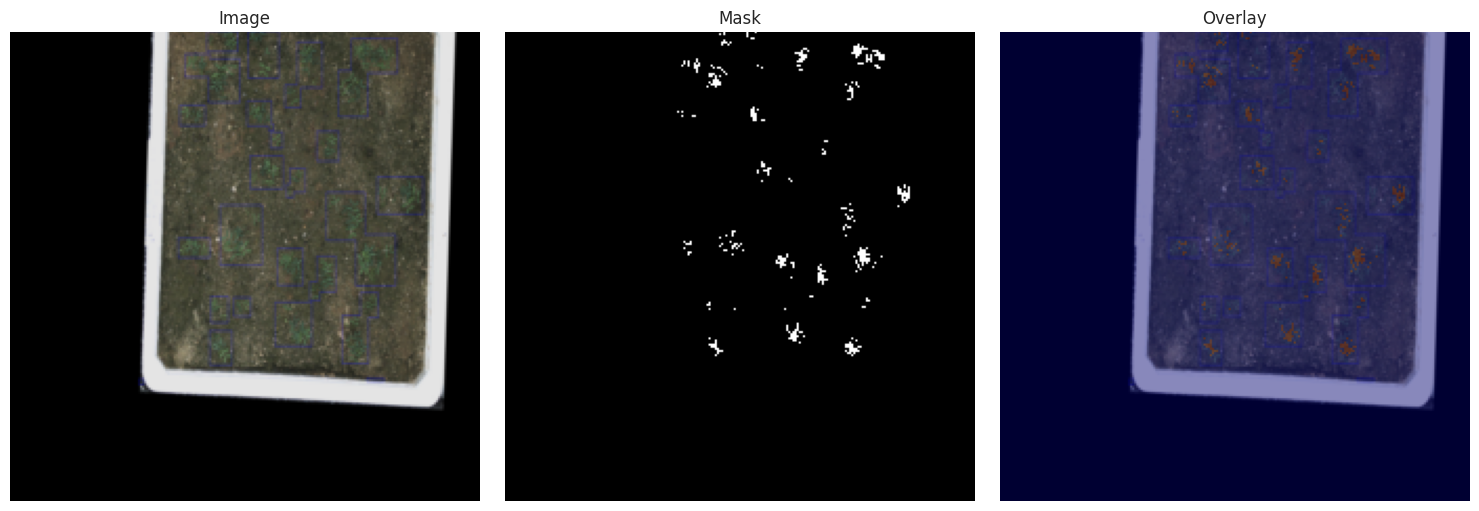

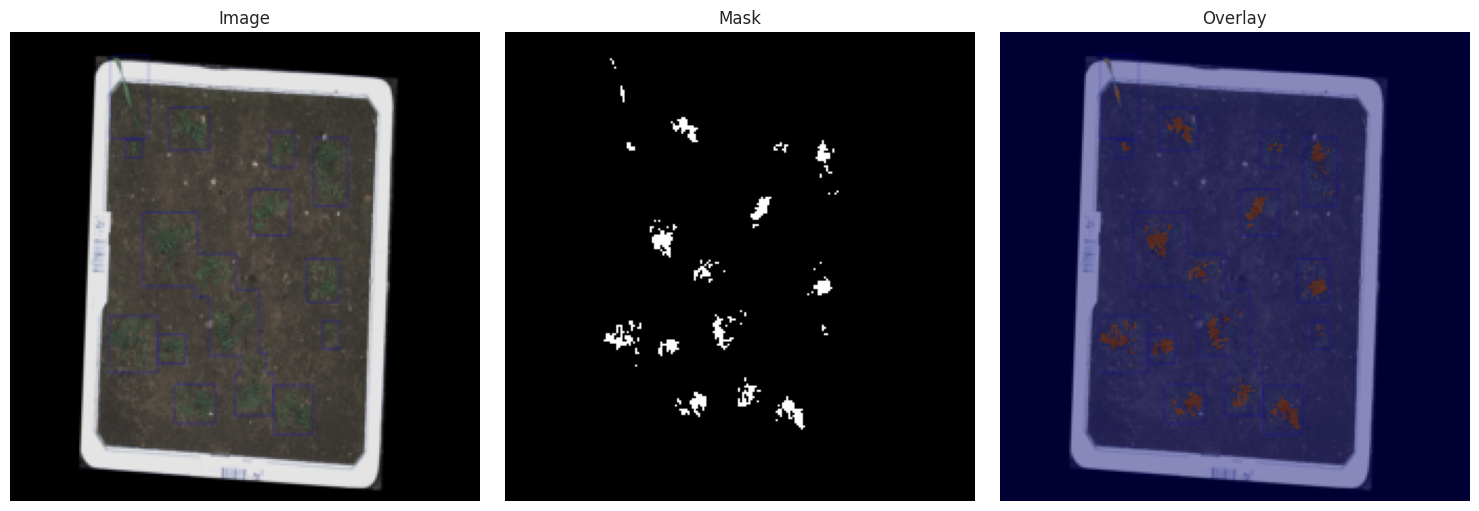

In [36]:
def imshow(img, mask):
    npimg = img.numpy().astype(float)
    npmask = mask.numpy().astype(float) * 256
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Image')
    axes[1].imshow(npmask, cmap='gray', vmin=0, vmax=1)
    axes[1].axis('off')
    axes[1].set_title('Mask')
    axes[2].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[2].imshow(npmask, alpha=0.4, cmap='jet', vmin=0, vmax=1)
    axes[2].axis('off')
    axes[2].set_title('Overlay')
    plt.tight_layout()
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

n_show = 2
for img, mask in zip(images[:n_show], labels[:n_show]):
  imshow(img, mask)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [38]:
def get_accuracy(output, mask) -> float:
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def get_mIoU(output, mask, smooth=1e-10, n_classes=2) -> float:
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        output = output.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        iou_per_class = []

        for clas in range(0, n_classes):
            true_class = output == clas
            true_label = mask == clas
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [39]:
def train(model, criterion, optimizer, epochs: int, n_print: int) -> tuple:
    train_accuracies = []
    train_iou_scores = []
    test_accuracies = []
    test_iou_scores = []
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        iou_score = 0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            iou_score += get_mIoU(outputs, labels)
            accuracy += get_accuracy(outputs, labels)
        test_accuracy = 0
        test_iou_score = 0
        with torch.no_grad():
            for _, data in enumerate(testloader):
                image_tiles, mask_tiles = data
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                outputs = model(image)
                test_iou_score += get_mIoU(outputs, mask)
                test_accuracy += get_accuracy(outputs, mask)
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_accuracy = accuracy / len(trainloader)
        epoch_test_accuracy = test_accuracy / len(testloader)
        epoch_train_iou = iou_score / len(trainloader)
        epoch_test_iou = test_iou_score / len(testloader)
        train_accuracies.append(epoch_train_accuracy)
        train_iou_scores.append(epoch_train_iou)
        test_accuracies.append(epoch_test_accuracy)
        test_iou_scores.append(epoch_test_iou)
        if (epoch + 1) % n_print == 0:
            print(f"Epoch {epoch + 1}:")
            print(f"  Train Loss: {epoch_train_loss:.4f}")
            print(f"  Train Accuracy: {epoch_train_accuracy:.4f} | Train mIoU: {epoch_train_iou:.4f}")
            print(f"  Test Accuracy:  {epoch_test_accuracy:.4f} | Test mIoU:  {epoch_test_iou:.4f}")
            print("-" * 60)

    return (train_accuracies, train_iou_scores, test_accuracies, test_iou_scores)

def get_criterion_optimizer(model):
    return nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def show_metrics(metrics_dict, metric_name="Accuracy", title="Model Comparison"):
    """
    Визуализирует метрики для нескольких моделей
    """
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", n_colors=len(metrics_dict)*2)

    for idx, (model_name, (train_metric, test_metric)) in enumerate(metrics_dict.items()):
        plt.plot(train_metric,
                 label=f'{model_name} - Train',
                 color=palette[idx*2],
                 linestyle='-',
                 linewidth=2)

        plt.plot(test_metric,
                 label=f'{model_name} - Test',
                 color=palette[idx*2+1],
                 linestyle='--',
                 linewidth=2)

    plt.title(f"{title} ({metric_name})", fontsize=14, pad=20)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

In [40]:
model_unet = smp.Unet("mobilenet_v2", encoder_weights="imagenet", classes=2)
model_unet = model_unet.to(device)
criterion, optimizer = get_criterion_optimizer(model_unet)

In [41]:
train_acc_unet, train_iou_unet, test_acc_unet, test_iou_unet = train(model_unet, criterion, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 2.5249
  Train Accuracy: 0.9064 | Train mIoU: 0.4588
  Test Accuracy:  0.9615 | Test mIoU:  0.4855
------------------------------------------------------------
Epoch 2:
  Train Loss: 1.4474
  Train Accuracy: 0.9727 | Train mIoU: 0.4899
  Test Accuracy:  0.9777 | Test mIoU:  0.4901
------------------------------------------------------------
Epoch 3:
  Train Loss: 1.0512
  Train Accuracy: 0.9799 | Train mIoU: 0.4904
  Test Accuracy:  0.9786 | Test mIoU:  0.4894
------------------------------------------------------------
Epoch 4:
  Train Loss: 0.9131
  Train Accuracy: 0.9793 | Train mIoU: 0.4898
  Test Accuracy:  0.9787 | Test mIoU:  0.4894
------------------------------------------------------------
Epoch 5:
  Train Loss: 0.8591
  Train Accuracy: 0.9802 | Train mIoU: 0.4902
  Test Accuracy:  0.9787 | Test mIoU:  0.4894
------------------------------------------------------------
Epoch 6:
  Train Loss: 0.8199
  Train Accuracy: 0.9796 | Train mIoU: 0.4898
  Test Ac

In [43]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Custom2Conv(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(Custom2Conv, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [44]:
model_custom_2conv = Custom2Conv().to(device)
criterion, optimizer = get_criterion_optimizer(model_custom_2conv)

In [45]:
train_acc_custom_2conv, train_iou_custom_2conv, test_acc_custom_2conv, test_iou_custom_2conv = train(model_custom_2conv, criterion, optimizer, epochs=n_epochs, n_print=1)

Epoch 1:
  Train Loss: 5.5686
  Train Accuracy: 0.5554 | Train mIoU: 0.2972
  Test Accuracy:  0.9573 | Test mIoU:  0.5673
------------------------------------------------------------
Epoch 2:
  Train Loss: 2.4068
  Train Accuracy: 0.9806 | Train mIoU: 0.6243
  Test Accuracy:  0.9844 | Test mIoU:  0.6213
------------------------------------------------------------
Epoch 3:
  Train Loss: 1.2412
  Train Accuracy: 0.9857 | Train mIoU: 0.6527
  Test Accuracy:  0.9857 | Test mIoU:  0.6468
------------------------------------------------------------
Epoch 4:
  Train Loss: 0.8515
  Train Accuracy: 0.9869 | Train mIoU: 0.6919
  Test Accuracy:  0.9863 | Test mIoU:  0.6552
------------------------------------------------------------
Epoch 5:
  Train Loss: 0.6732
  Train Accuracy: 0.9880 | Train mIoU: 0.7113
  Test Accuracy:  0.9874 | Test mIoU:  0.6817
------------------------------------------------------------
Epoch 6:
  Train Loss: 0.5815
  Train Accuracy: 0.9879 | Train mIoU: 0.7058
  Test Ac

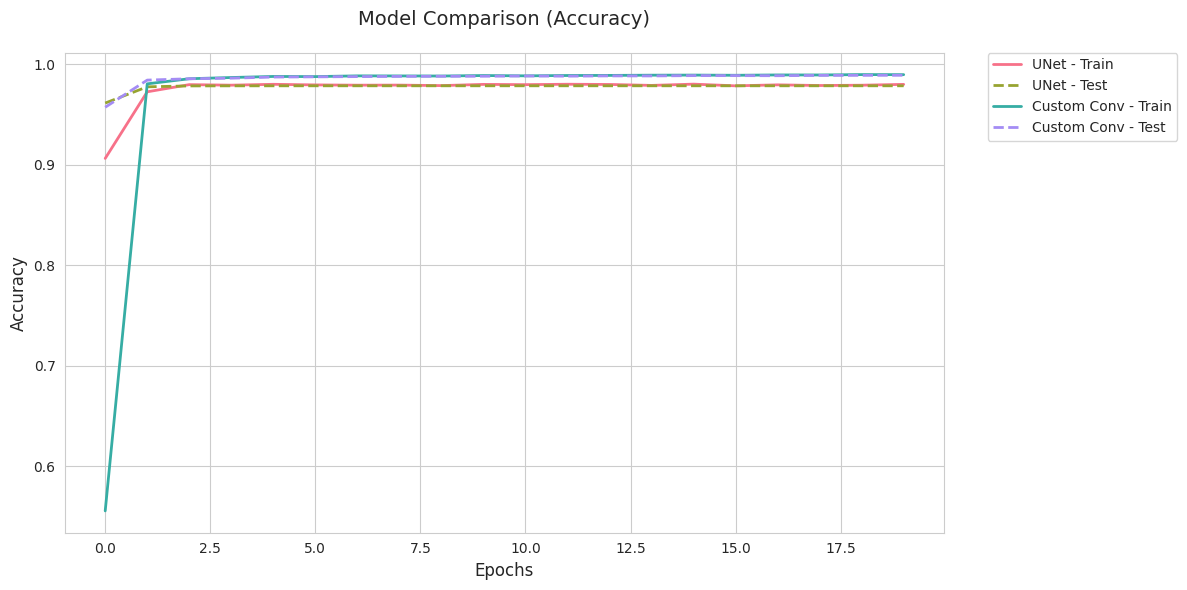

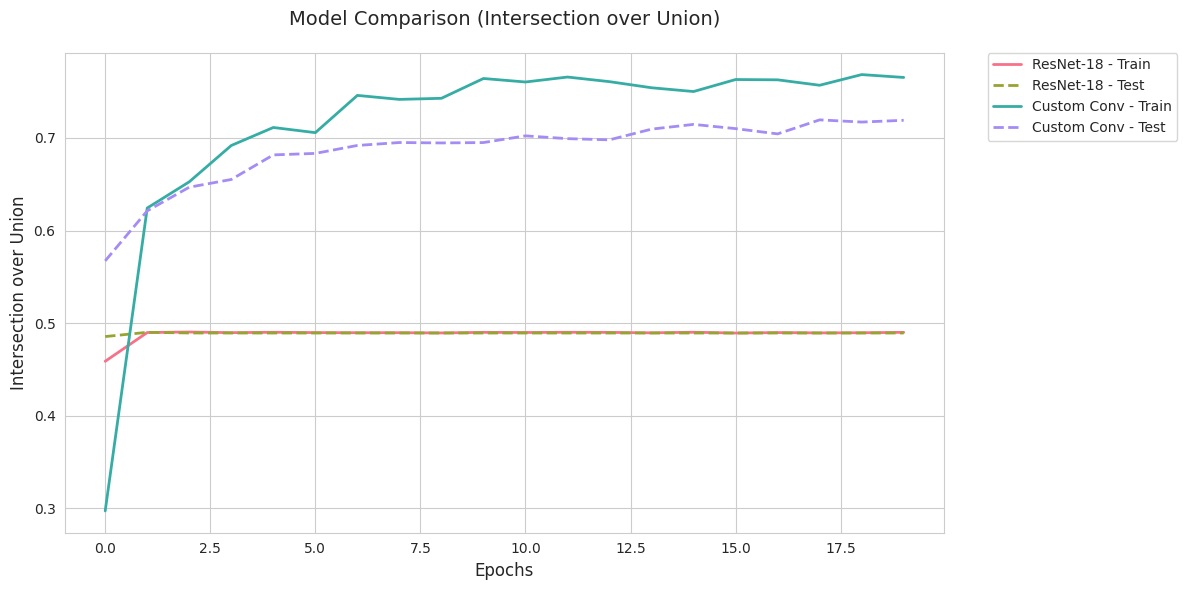

In [46]:
accuracy_data = {
    "UNet": (train_acc_unet, test_acc_unet),
    "Custom Conv": (train_acc_custom_2conv, test_acc_custom_2conv),
}
iou_data = {
    "ResNet-18": (train_iou_unet, test_iou_unet),
    "Custom Conv": (train_iou_custom_2conv, test_iou_custom_2conv),
}
show_metrics(accuracy_data, metric_name="Accuracy")
show_metrics(iou_data, metric_name="Intersection over Union")